In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import time

# Tekrarlanabilirlik için sabit rastgelelik
np.random.seed(42)

In [3]:
# MNIST verisinin çekilmesi ve ön işleme
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
veri_x = mnist.data.astype('float32') / 255.0
veri_y = mnist.target.astype('int')

# Eğitim/test ayrımı ve boyutlandırma
X_egitim, X_test, _, _ = train_test_split(veri_x, veri_y, test_size=0.2, random_state=42)
X_egitim = X_egitim.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [4]:
# Görüntüye Gaussian gürültüsü ekleme fonksiyonu
def gauss_gurultusu_ver(veri, ort=0, std=0.5):
    g_map = np.random.normal(ort, std, veri.shape)
    return np.clip(veri + g_map, 0, 1)

In [5]:
# 2D konvolüsyon: kenarlarda yansıtmalı pad ile
def konvol_uygula(img, cekirdek):
    boy, en = cekirdek.shape
    p_b, p_e = boy // 2, en // 2
    yastik = np.pad(img, ((p_b, p_b), (p_e, p_e)), mode='reflect')
    sonuc = np.zeros_like(img)

    for sat in range(img.shape[0]):
        for sut in range(img.shape[1]):
            alan = yastik[sat:sat+boy, sut:sut+en]
            sonuc[sat, sut] = np.sum(alan * cekirdek)

    return sonuc

In [6]:
# Görsel karşılaştırma - dikey ızgara
def dikey_gorsel_karsilastir(orjinaller, gurultuler, temizler=None, adet=3):
    kolon_sayisi = 3 if temizler is not None else 2
    fig, eksen = plt.subplots(adet, kolon_sayisi, figsize=(kolon_sayisi * 4, adet * 4))

    for i in range(adet):
        eksen[i, 0].imshow(orjinaller[i], cmap='gray')
        eksen[i, 0].set_title("Giriş Görseli")
        eksen[i, 0].axis('off')

        eksen[i, 1].imshow(gurultuler[i], cmap='gray')
        eksen[i, 1].set_title("Gürültülü Versiyon")
        eksen[i, 1].axis('off')

        if temizler is not None:
            eksen[i, 2].imshow(temizler[i], cmap='gray')
            eksen[i, 2].set_title("Filtrelenmiş")
            eksen[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# Öğrenilebilir cross filtreli model
def capraz_filtremodeli(veri_giris, alpha=0.01, boyut=5, tekrar=100, g_ort=0, g_std=0.5):
    # Başlangıç çekirdeği (cross tipi)
    filtre = np.zeros((boyut, boyut))
    merkez = boyut // 2
    filtre[merkez, :] = np.random.normal(0, 0.001, boyut)
    filtre[:, merkez] = np.random.normal(0, 0.001, boyut)
    filtre[merkez, merkez] = np.random.normal(0, 0.001)

    # Sadece ortadaki artı şekli öğrenilecek
    ogrenilecek_kisiler = np.zeros((boyut, boyut))
    ogrenilecek_kisiler[merkez, :] = 1
    ogrenilecek_kisiler[:, merkez] = 1

    hata_listesi = []

    for dongu in range(tekrar):
        toplam_kayip = 0
        grad_toplam = np.zeros_like(filtre)

        for goruntu in veri_giris:
            gurultu_goruntu = gauss_gurultusu_ver(goruntu, ort=g_ort, std=g_std)
            cikti = konvol_uygula(gurultu_goruntu, filtre)

            kayip = np.linalg.norm(goruntu - cikti)
            toplam_kayip += kayip

            fark_haritasi = 2 * (cikti - goruntu) / (28 * 28)
            padlanmis = np.pad(gurultu_goruntu, ((2, 2), (2, 2)), mode='reflect')

            for i in range(28):
                for j in range(28):
                    parca = padlanmis[i:i + boyut, j:j + boyut]
                    grad_toplam += fark_haritasi[i, j] * parca

        ort_kayip = toplam_kayip / len(veri_giris)
        ort_grad = grad_toplam / len(veri_giris)

        # Güncelleme sadece cross alanında yapılır
        filtre -= alpha * ort_grad * ogrenilecek_kisiler
        hata_listesi.append(ort_kayip)


    return filtre, hata_listesi

Model V2 (Çapraz Çekirdek) başlatılıyor...
Model eğitimi tamamlandı. Süre: 693.73 sn


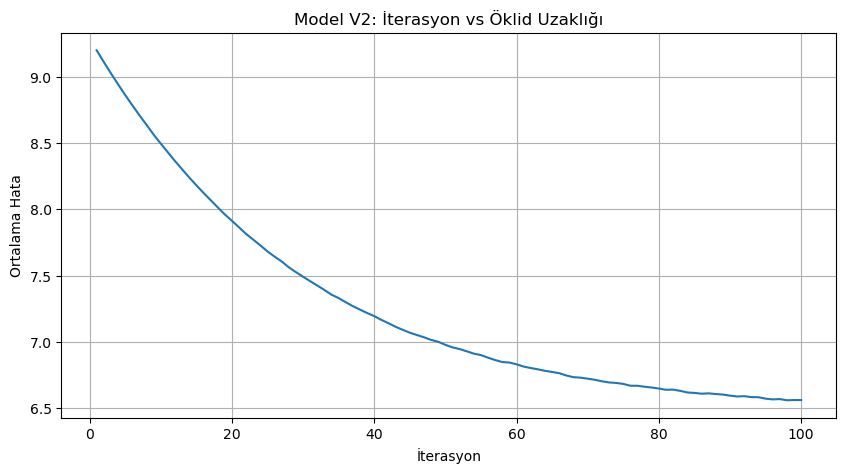

In [9]:
# Model eğitimi başlatılır
print("Model V2 (Çapraz Çekirdek) başlatılıyor...")
basla = time.time()
ornek_giris = X_egitim[:1000]
ogr_filtre, hata_gecmisi = capraz_filtremodeli(ornek_giris)
print(f"Model eğitimi tamamlandı. Süre: {time.time() - basla:.2f} sn")

# Hata eğrisi
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(hata_gecmisi) + 1), hata_gecmisi)
plt.title('Model V2: İterasyon vs Öklid Uzaklığı')
plt.xlabel('İterasyon')
plt.ylabel('Ortalama Hata')
plt.grid(True)
plt.show()

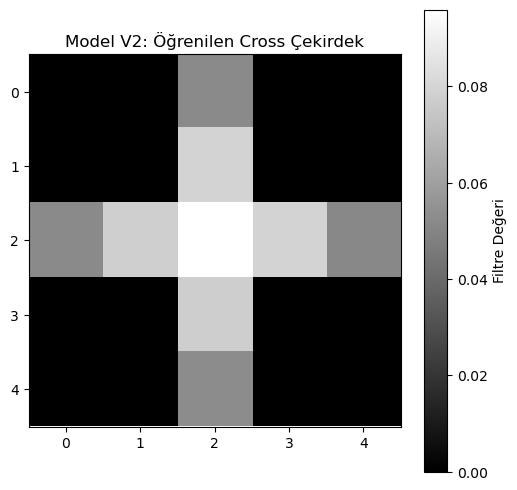

In [10]:
# Kernel görselleştirme
plt.figure(figsize=(6, 6))
plt.imshow(ogr_filtre, cmap='gray')
plt.colorbar(label='Filtre Değeri')
plt.title('Model V2: Öğrenilen Cross Çekirdek')
plt.show()

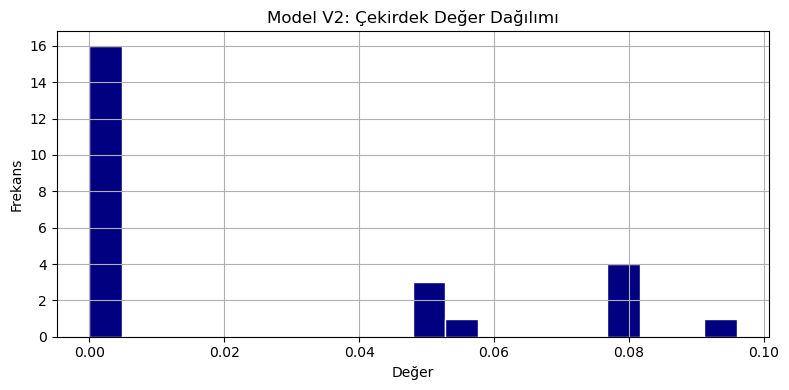

In [11]:
# Histogram grafiği
plt.figure(figsize=(8, 4))
plt.hist(ogr_filtre.flatten(), bins=20, color='navy', edgecolor='white')
plt.title('Model V2: Çekirdek Değer Dağılımı')
plt.xlabel('Değer')
plt.ylabel('Frekans')
plt.grid(True)
plt.tight_layout()
plt.show()

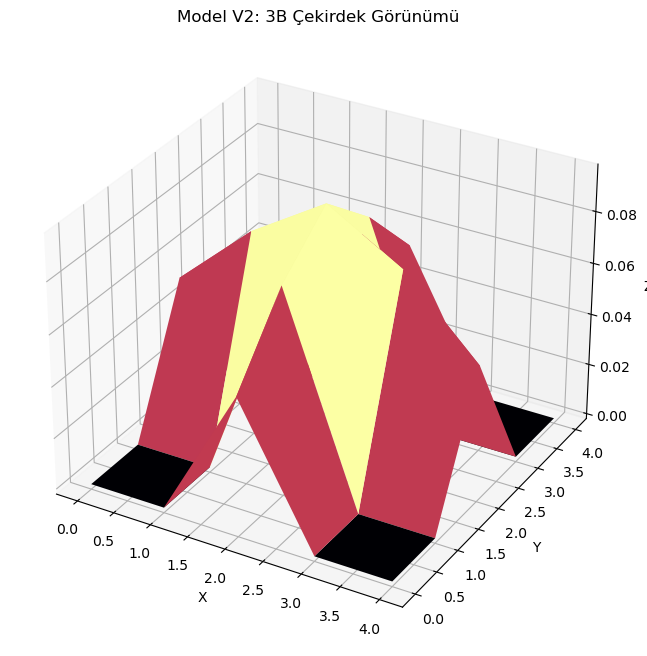

In [12]:
# 3D yüzey grafiği
k = ogr_filtre.shape[0]
x, y = np.meshgrid(np.arange(k), np.arange(k))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, ogr_filtre, cmap='inferno')
ax.set_title('Model V2: 3B Çekirdek Görünümü')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

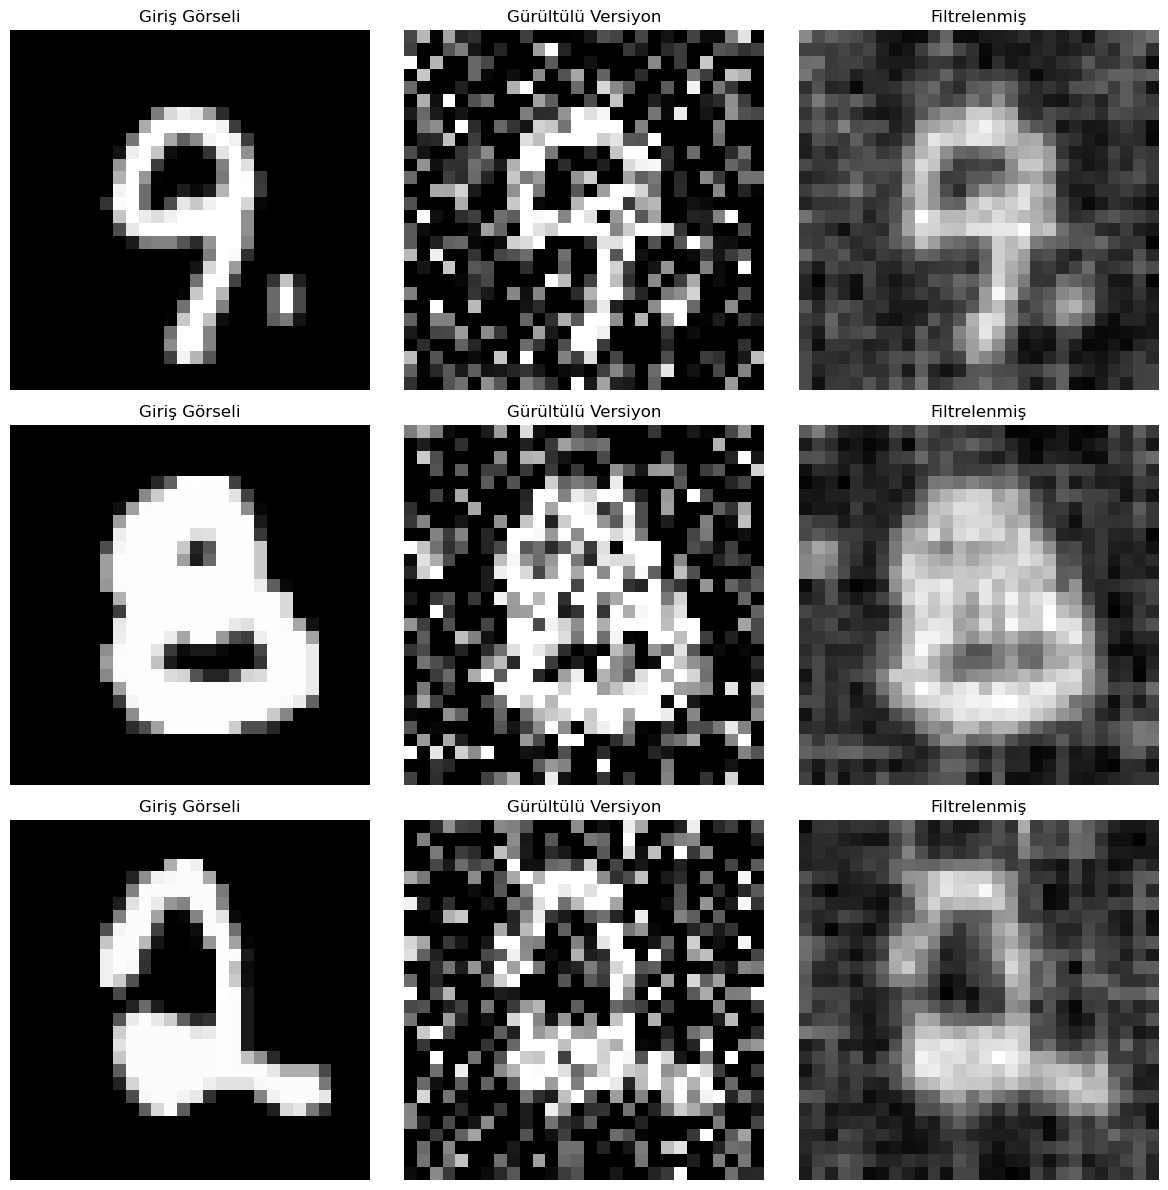

In [17]:
# Test setinden 3 örnek için karşılaştırma
rastgele_idx = np.random.choice(len(X_test), 3, replace=False)
temiz = X_test[rastgele_idx]
gurultulu = gauss_gurultusu_ver(temiz)
filtrelenmis = np.array([konvol_uygula(g, ogr_filtre) for g in gurultulu])

# Görsel karşılaştırma
dikey_gorsel_karsilastir(temiz, gurultulu, filtrelenmis)